In [3]:
!pip -q install nltk==3.9.1
import nltk
nltk.download("punkt")
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Tokenizador de oraciones en español (evita punkt_tab)
spanish_sent_tok = nltk.data.load("tokenizers/punkt/spanish.pickle")

WORD_RE = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+")

def sent_tokenize_es(text:str):
    try:
        sents = [s.strip() for s in spanish_sent_tok.tokenize(text) if s.strip()]
    except Exception:
        sents = re.split(r"(?<=[\.\!\?…;:])\s+", text.strip())
        sents = [s for s in sents if s]
    return sents

def word_tokenize_es(text:str):
    return WORD_RE.findall(text)

# Si el texto tiene solo una oración, intentamos dividirlo
def ensure_multi_sentence(sents, min_tokens=6):
    if len(sents) >= 2: return sents
    parts = re.split(r"[;:—–]|, (?=[A-ZÁÉÍÓÚÜÑa-záéíóúüñ])", sents[0])
    parts = [p.strip() for p in parts if len(word_tokenize_es(p)) >= min_tokens]
    return parts if len(parts) >= 2 else sents

VOWELS = set("aeiouáéíóúüAEIOUÁÉÍÓÚÜ")
def syllable_count_es(word:str)->int:
    prev_v=False; groups=0
    for ch in word:
        v = ch in VOWELS
        if v and not prev_v: groups += 1
        prev_v = v
    return max(groups,1)


In [5]:
def mattr(tokens, window=50):
    n=len(tokens)
    if n<2: return np.nan
    w=min(window,n); low=[t.lower() for t in tokens]
    vals=[len(set(low[i:i+w]))/w for i in range(n-w+1)]
    return float(np.mean(vals)) if vals else np.nan

def burstiness_es(text:str)->float:
    sents = ensure_multi_sentence(sent_tokenize_es(text))
    if len(sents)<2: return np.nan
    lens=[len(word_tokenize_es(s)) for s in sents]
    return float(np.std(lens,ddof=1)/(np.mean(lens)+1e-8))

def stylometry_es(text:str):
    sents = ensure_multi_sentence(sent_tokenize_es(text))
    words = word_tokenize_es(text); n_w=len(words)
    if n_w==0:
        return dict(mattr=np.nan,sent_len_avg=np.nan,word_len_avg=np.nan,
                    punct_per_100w=np.nan,syl_per_word=np.nan,fh=np.nan,szigriszt=np.nan)
    sent_len_avg=float(np.mean([len(word_tokenize_es(s)) for s in sents]))
    word_len_avg=float(np.mean([len(w) for w in words]))
    punct_per_100w=(sum(c in ".,;:¡!¿?—–-…()[]{}\"'" for c in text)/n_w)*100
    syl_per_word=sum(syllable_count_es(w) for w in words)/n_w
    words_per_sent=n_w/max(1,len(sents))
    fh=206.84-60.0*syl_per_word-1.02*words_per_sent
    sz=206.835-62.3*syl_per_word-words_per_sent
    return dict(mattr=float(mattr(words)),
                sent_len_avg=sent_len_avg,word_len_avg=word_len_avg,
                punct_per_100w=float(punct_per_100w),syl_per_word=float(syl_per_word),
                fh=float(fh),szigriszt=float(sz))


In [6]:
ejemplos = [
    # HUMANOS (5)
    ("humano","Ayer en el seminario discutimos resultados contradictorios; algunos eran sólidos, "
              "pero surgieron dudas metodológicas. Decidimos replicar el experimento con más control."),
    ("humano","El equipo improvisó un plan B, menos formal y más iterativo. No fue elegante, pero funcionó "
              "y cambió el ánimo del grupo en veinte minutos."),
    ("humano","Siempre que preparo una rúbrica, la reviso con los estudiantes: acordamos criterios, ejemplos "
              "y niveles de logro para evitar ambigüedades. Ese diálogo vuelve más justo el proceso."),
    ("humano","El fin de semana visité a mis abuelos y terminamos recordando historias casi olvidadas. Entre risas y fotos "
              "viejas comprendí que la memoria también se cultiva con cariño y tiempo."),
    ("humano","En el taller de hoy cada quien presentó su avance con honestidad. Hubo críticas y también apoyo, "
              "así que salimos con tareas claras y mejor ánimo."),

    # IA (5)
    ("ia","La inteligencia artificial es un campo interdisciplinario que combina estadística y computación "
          "para aprender patrones complejos. Su finalidad es optimizar la toma de decisiones en distintos dominios."),
    ("ia","Este informe describe un marco metodológico para la evaluación reproducible de modelos. Incluye la definición "
          "de métricas, procedimientos de validación y criterios de comparación entre conjuntos de datos."),
    ("ia","El modelo propuesto integra aprendizaje profundo con algoritmos de optimización. De esta manera, mejora la "
          "precisión y reduce la varianza en escenarios de alta dimensionalidad."),
    ("ia","El estudio muestra que la normalización de datos antes del entrenamiento incrementa la estabilidad del modelo. "
          "Además, se observa una reducción del error medio cuadrático en pruebas controladas."),
    ("ia","La propuesta establece un proceso estandarizado para comparar arquitecturas de redes neuronales. Se detallan "
          "las fases de preprocesamiento, entrenamiento y evaluación en diferentes contextos experimentales.")
]

rows=[]
for i,(lab,txt) in enumerate(ejemplos,1):
    feats=stylometry_es(txt)
    rows.append({"id":f"ex_{i:02d}","true_label":lab,"burstiness":burstiness_es(txt),**feats})
df=pd.DataFrame(rows)
pd.set_option("display.precision",3)
df


,id,true_label,burstiness,mattr,sent_len_avg,word_len_avg,punct_per_100w,syl_per_word,fh,szigriszt
0,ex_01,humano,0.471,0.952,10.5,6.857,19.048,2.810,27.559,21.302
1,ex_02,humano,0.170,0.920,12.5,4.400,16.000,1.960,76.490,72.227
2,ex_03,humano,0.681,1.000,13.5,5.481,18.519,2.296,55.292,50.276
3,ex_04,humano,0.094,0.933,15.0,4.933,6.667,2.067,67.540,63.082
4,ex_05,humano,0.109,0.923,13.0,4.500,11.538,1.885,80.503,76.423
5,ex_06,ia,0.262,0.926,13.5,6.370,7.407,2.630,35.292,29.509
6,ex_07,ia,0.202,0.821,14.0,6.214,10.714,2.571,38.274,32.635
7,ex_08,ia,0.283,0.880,12.5,5.960,12.000,2.560,40.490,34.847
8,ex_09,ia,0.202,0.893,14.0,5.857,10.714,2.357,51.131,45.985
9,ex_10,ia,0.057,0.960,12.5,7.160,12.000,2.920,18.890,12.419


### Modelos


In [7]:
!pip -q install scikit-learn


Matriz de confusión (OOF):
[[3 2]
 [0 5]]


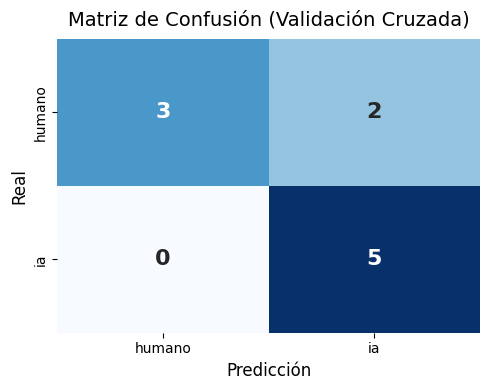


Reporte OOF:
              precision    recall  f1-score   support

      humano      1.000     0.600     0.750         5
          ia      0.714     1.000     0.833         5

    accuracy                          0.800        10
   macro avg      0.857     0.800     0.792        10
weighted avg      0.857     0.800     0.792        10

ROC-AUC OOF: 0.8


In [8]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

feat_cols = ['fh','punct_per_100w','syl_per_word','word_len_avg','burstiness','mattr']
X = df[feat_cols].astype(float).values
y = (df['true_label'].str.lower()=='ia').astype(int).values

loo = LeaveOneOut()
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200, solver='liblinear', class_weight='balanced'))
])

# Predicciones out-of-fold para TODAS las muestras
y_proba_oof = cross_val_predict(pipe, X, y, cv=loo, method='predict_proba')[:,1]
y_pred_oof  = (y_proba_oof >= 0.5).astype(int)

print("Matriz de confusión (OOF):")
print(confusion_matrix(y, y_pred_oof))

cm = confusion_matrix(y, y_pred_oof)
labels = ['humano', 'ia']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False,
            annot_kws={"size":16, "weight":"bold"})

plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Real", fontsize=12)
plt.title("Matriz de Confusión (Validación Cruzada)", fontsize=14, pad=10)
plt.tight_layout()
plt.show()


print("\nReporte OOF:")
print(classification_report(y, y_pred_oof, target_names=['humano','ia'], digits=3, zero_division=0))

print("ROC-AUC OOF:", round(roc_auc_score(y, y_proba_oof), 3))
